In [39]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
sns.set(color_codes=True)
%matplotlib inline

In [40]:
runs = MlflowClient(tracking_uri="file:/data/logs/kristian/mlruns").search_runs(
  experiment_ids="10",
  filter_string="tags.stage = 'eval'",
)

In [41]:
data = np.zeros((8, 9))

In [42]:
for run in runs:
    qta = run.data.metrics['q_c_test/acc']
    ap = int(run.data.params['quantization/activation_precision'])
    wp = int(run.data.params['quantization/weight_precision'])
    data[ap, wp] = qta



In [68]:
#fig, ax = plt.subplots(figsize=(10,8))
#fig = sns.heatmap(data[2:,2:], annot=True, xticklabels=[2,3,4,5,6,7,8], yticklabels=[2,3,4,5,6,7])
#plt.xlabel("Wieight precision")
#plt.ylabel("Activation precision")
#plt.title("ResNet")
# plt.show(fig)
#plt.savefig('/home/k.schwienbacher/quantization-robustness/data/resnet-heatmap-c.jpg')

In [69]:
experiments = [
    {'id': "14", 'name': 'squeezenet' }, 
    {'id': "12", 'name': 'lenet' }, 
    {'id': "10", 'name': 'resnet' }, 
    {'id': "11", 'name': 'lenetplus' },
]

In [70]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  squeeze_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval'",
    output_format="pandas"
  )
  run = squeeze_runs[squeeze_runs["params.quantization/activation_precision"] == '7'].set_index("params.quantization/weight_precision")
  run['name'] = exp['name']
  runs.append((exp['name'], run))


In [75]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_test/acc"]

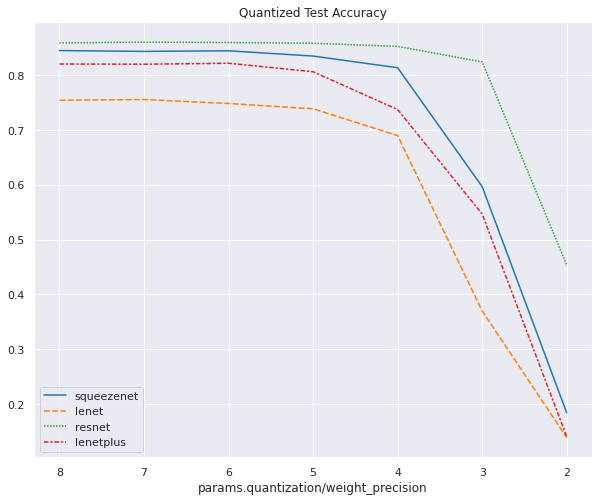

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
sns.lineplot(data=df)
plt.title("Quantized Test Accuracy")
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/srl-comparison.jpg')


In [78]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  squeeze_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval'",
    output_format="pandas"
  )
  run = squeeze_runs[squeeze_runs["params.quantization/weight_precision"] == '8'].set_index("params.quantization/activation_precision")
  run['name'] = exp['name']
  runs.append((exp['name'], run))

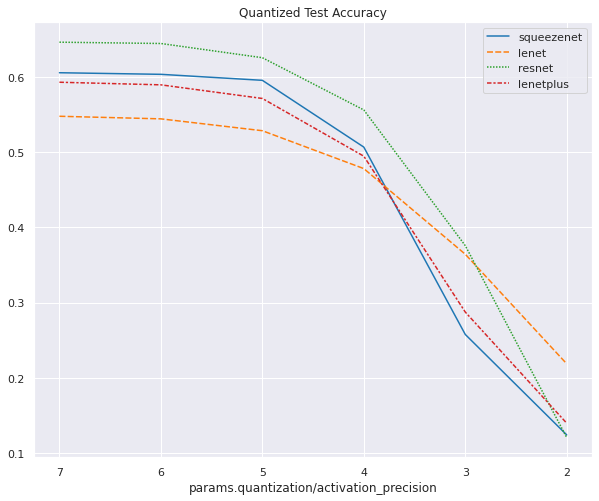

In [80]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_c_test/acc"]
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
sns.lineplot(data=df)
plt.title("Quantized Test Accuracy")
plt.savefig('/home/k.schwienbacher/quantization-robustness/data/srl-c-act-comparison.jpg')